At first some python libraries are imported:

In [19]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
from matplotlib.ticker import FuncFormatter

The model data is imported as a dataset:

In [2]:
press = xr.open_dataset("/students_files/data/slo0043_echam6_code151_mm_1001-8850.ncslo0043_echam6_code151_mm_1001-8850.nc")

The longitude and latitude coordinates are adjusted.

In [3]:
# adjust values of lon and lat and show dataset

def adjust_lon_lat(ds, lon_name, lat_name, reverse = False):
    """Adjusts longitude from 0 to 360 to -180 to 180 and reverses latitude."""
    if reverse == True:
        ds = ds.reindex({lat_name:ds[lat_name][::-1]})
    ds['_longitude_adjusted'] = xr.where(
        ds[lon_name] > 180,
        ds[lon_name] - 360,
        ds[lon_name])
    ds = (ds
          .swap_dims({lon_name: '_longitude_adjusted'})
          .sel(**{'_longitude_adjusted': sorted(ds._longitude_adjusted)})
          .drop(lon_name))
    ds = ds.rename({'_longitude_adjusted': lon_name})
    return ds

press = adjust_lon_lat(press, lon_name="lon", lat_name="lat", reverse=True)

print(press)

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 192, time: 94200)
Coordinates:
  * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
  * time     (time) float64 1.001e+07 1.001e+07 1.001e+07 ... 8.85e+07 8.85e+07
  * lon      (lon) float64 -178.1 -176.2 -174.4 -172.5 ... 176.2 178.1 180.0
Data variables:
    var151   (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Dec 16 13:07:48 2019: cdo -f nc -g t63grid copy /work/m...
    institution:  Max-Planck-Institute for Meteorology
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...


The coastal outline is prepared:

In [14]:
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def subplot_cartopy_nice_baltic(ax):    
    """
    Adjust cartopy plots for the Baltic Sea
    """
    ax.set_aspect("auto")
    ax.coastlines("10m")
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=2, color='gray', alpha=0.0, linestyle='-')
    gl.top_labels  = False
    gl.left_labels  = True
    gl.right_labels  = False
    gl.xlines = True
    gl.ylines = True
    gl.xlocator = mticker.FixedLocator(list(np.arange(-90, 60, 10)))
    gl.ylocator = mticker.FixedLocator(list(np.arange(-60, 80, 5)))

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # Change tick label size
    gl.xlabel_style = {'size': 22}
    gl.ylabel_style = {'size': 22}

    ax.spines['geo'].set_linewidth(1)
    ax.spines['geo'].set_edgecolor('black')
    ax.set_aspect('auto')

# North Atlantic Oscillation

In [5]:
# NAO

# dominant winter pattern (either nao strong and weather warm and wet or nao weak and siberian influence stronger so winters are cold and dry; in summer more difficult; same with precipitation

In this notebook we will be looking at the atmospheric pressure difference at sea level between the Icelandic Low and the Azores High. Oscillation in this pressure gradient is called the North Atlantic Oscillation (NAO).

In [6]:
# select region
press_nao = press.sel(lat=slice(25,70), lon=slice(-60,0))
press_nao_mean = press_nao.mean(dim=['time'])

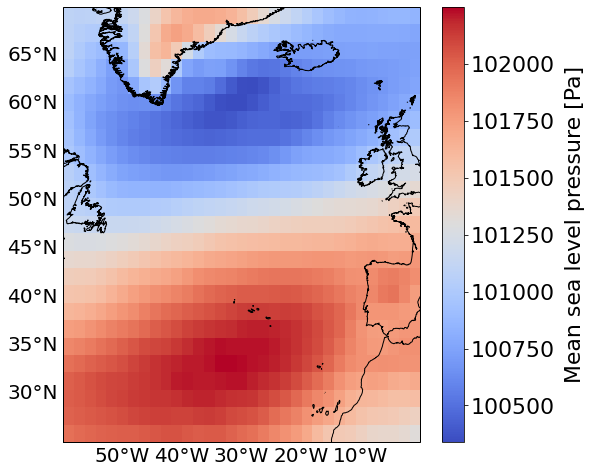

In [18]:
# plot the heatmap
fig, ax = plt.subplots(1,1, figsize=(8,8), subplot_kw=dict(projection=ccrs.PlateCarree()))
#fig.suptitle('Pressure in Nothern Atlantic, 6000BCE-1850CE mean', fontweight='bold')
#press_nao_mean = press_nao_mean['var151'] 
im = ax.imshow(press_nao_mean,
               extent=[-60, 0, 25, 70],
               transform=ccrs.PlateCarree(),
               cmap='coolwarm',
               origin='lower'
)
subplot_cartopy_nice_baltic(ax)
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22)
cbar.set_label('Mean sea level pressure [Pa]', fontsize = '22', labelpad=10)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [21]:
press_range_il = press.sel(lat=slice(55,68), lon=slice(-37,-24))
press_range_ah = press.sel(lat=slice(27,40), lon=slice(-39,-26))
press_il = np.zeros(94200)
press_ah = np.zeros(94200)

In [22]:
for i in range (0, 94200):
    press_il[i] = press_range_il['var151'].isel(time=i).min(dim=['lat','lon'])
    press_ah[i] = press_range_ah['var151'].isel(time=i).max(dim=['lat','lon'])

You can recognize the two pressure systems. We will define the pressure of the Icelandic Low as the pressure at 60.62°N, 31.88°W and the pressure of the Azores High as the pressure at 32.64°N, 31.88°W. Let's take a look at the pressure differnce:

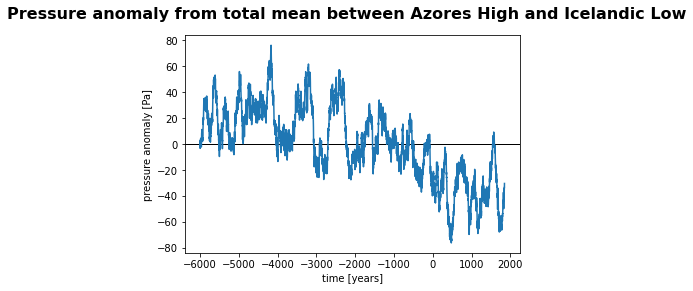

In [23]:
# Calculating pressure difference
delta_press_monthly = press_ah - press_il

# Calculating annual delta pressure
window_size = 12
delta_press = [np.mean(delta_press_monthly[i:i+window_size]) for i in range(0, len(delta_press_monthly), window_size)]
delta_press = np.array(delta_press)

# Converting difference to difference anomaly
delta_press_mean = delta_press.mean()
delta_press -= delta_press_mean

# Add time coordinate
time = np.arange(-6000,1850)

# Calculate the moving average
window_size = 150
delta_press = np.convolve(delta_press, np.ones(window_size)/window_size, mode='same')

fig, ax = plt.subplots()
fig.suptitle('Pressure anomaly from total mean between Azores High and Icelandic Low', fontsize=16, fontweight='bold');
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.plot(time, delta_press)
ax.set_xlabel('time [years]')
ax.set_ylabel('pressure anomaly [Pa]');

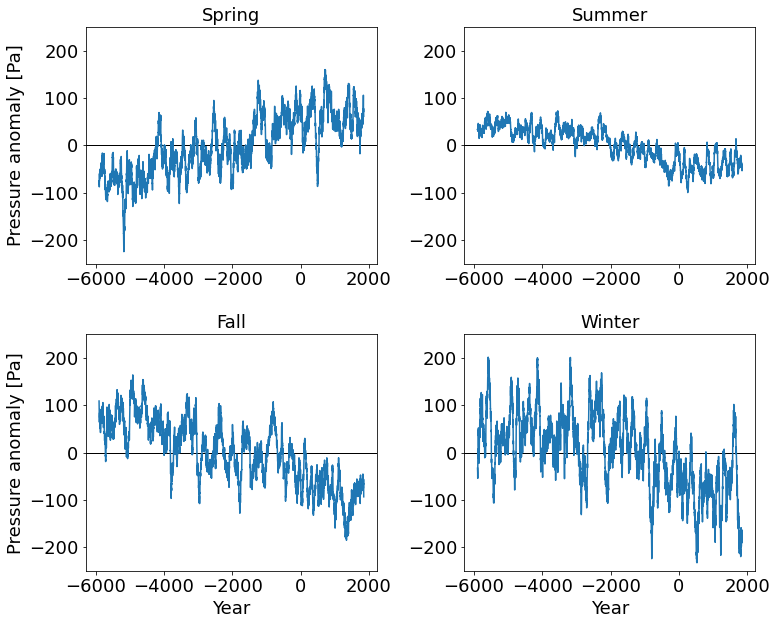

In [31]:
time = np.arange(0,94200)
delta_press_monthly = xr.DataArray(delta_press_monthly, dims=['time'], coords={'time': time})
rolling_data = delta_press_monthly.isel(time=slice(2, None))
rolling_data = rolling_data.rolling(time=3, center=False, min_periods=3).mean()
rolling_data = rolling_data[2::3]
seasonal_delta_press = xr.Dataset({"var151": ("time", rolling_data)}, coords={"time": rolling_data.coords["time"]})


# Creating spring_delta_press DataArray and applying 200y MA
spring_delta_press = seasonal_delta_press['var151'][0::4]
delta_press_mean = spring_delta_press.mean(dim=['time'])
delta_press_mean = float(delta_press_mean.values)
spring_delta_press -= delta_press_mean
spring_delta_press.coords['time'] = range(-6000, -6000+len(spring_delta_press))
spring_delta_press = spring_delta_press.rolling(time=100).mean()

# Creating summer_delta_press DataArray and applying 200y MA
summer_delta_press = seasonal_delta_press['var151'][1::4]
delta_press_mean = summer_delta_press.mean(dim=['time'])
delta_press_mean = float(delta_press_mean.values)
summer_delta_press -= delta_press_mean
summer_delta_press.coords['time'] = range(-6000, -6000+len(summer_delta_press))
summer_delta_press = summer_delta_press.rolling(time=100).mean()

# Creating fall_delta_press DataArray and applying 200y MA
fall_delta_press = seasonal_delta_press['var151'][2::4]
delta_press_mean = fall_delta_press.mean(dim=['time'])
delta_press_mean = float(delta_press_mean.values)
fall_delta_press -= delta_press_mean
fall_delta_press.coords['time'] = range(-6000, -6000+len(fall_delta_press))
fall_delta_press = fall_delta_press.rolling(time=100).mean()

# Creating winter_delta_press DataArray and applying 200y MA
winter_delta_press = seasonal_delta_press['var151'][3::4]
delta_press_mean = winter_delta_press.mean(dim=['time'])
delta_press_mean = float(delta_press_mean.values)
winter_delta_press -= delta_press_mean
winter_delta_press.coords['time'] = range(-6000, -6000+len(winter_delta_press))
winter_delta_press = winter_delta_press.rolling(time=100).mean()


# Creating the four plots
fig, axs = plt.subplots(2, 2, figsize=(12,10), gridspec_kw={"hspace": 0.3, "wspace": 0.3})

im1 = axs[0,0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axs[0,0].plot(spring_delta_press['time'], spring_delta_press)
axs[0,0].set_title('Spring', fontsize=18)
#axs[0,0].set_xlabel('time [years]')
axs[0,0].set_ylabel('Pressure anomaly [Pa]', fontsize=18)
axs[0,0].tick_params(axis='both', labelsize=18)
axs[0,0].set_ylim([-250,250])

im2 = axs[0,1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axs[0,1].plot(summer_delta_press['time'], summer_delta_press)
axs[0,1].set_title('Summer', fontsize=18)
#axs[0,1].set_xlabel('time [years]')
#axs[0,1].set_ylabel('pressure anomaly [Pa]')
axs[0,1].tick_params(axis='both', labelsize=18)
axs[0,1].set_ylim([-250,250])

im3 = axs[1,0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axs[1,0].plot(fall_delta_press['time'], fall_delta_press)
axs[1,0].set_title('Fall', fontsize=18)
axs[1,0].set_xlabel('Year', fontsize=18)
axs[1,0].set_ylabel('Pressure anomaly [Pa]', fontsize=18)
axs[1,0].tick_params(axis='both', labelsize=18)
axs[1,0].set_ylim([-250,250])

im4 = axs[1,1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axs[1,1].plot(winter_delta_press['time'], winter_delta_press)
axs[1,1].set_title('Winter', fontsize=18)
axs[1,1].set_xlabel('Year', fontsize=18)
#axs[1,1].set_ylabel('pressure anomaly [Pa]')
axs[1,1].tick_params(axis='both', labelsize=18)
axs[1,1].set_ylim([-250,250]);

# fig.suptitle('Seasonal NAO pressure difference anomaly, 200y MA', fontsize=16, fontweight='bold');

plt.savefig("/students_files/marti/plots/res_15_nao_press_seasonal", bbox_inches='tight');